# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача**

Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


No handles with labels found to put in legend.


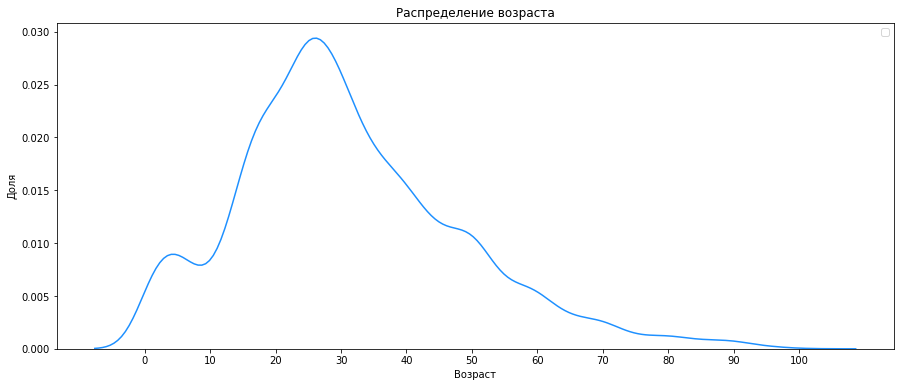

In [6]:
plt.figure(figsize=(15,6))
fig = sns.kdeplot(data=labels, x='real_age', color='dodgerblue')
fig.set_title('Распределение возраста')
fig.set(xlabel='Возраст', ylabel = 'Доля')
plt.legend()
plt.xticks(range(0, 110, 10));

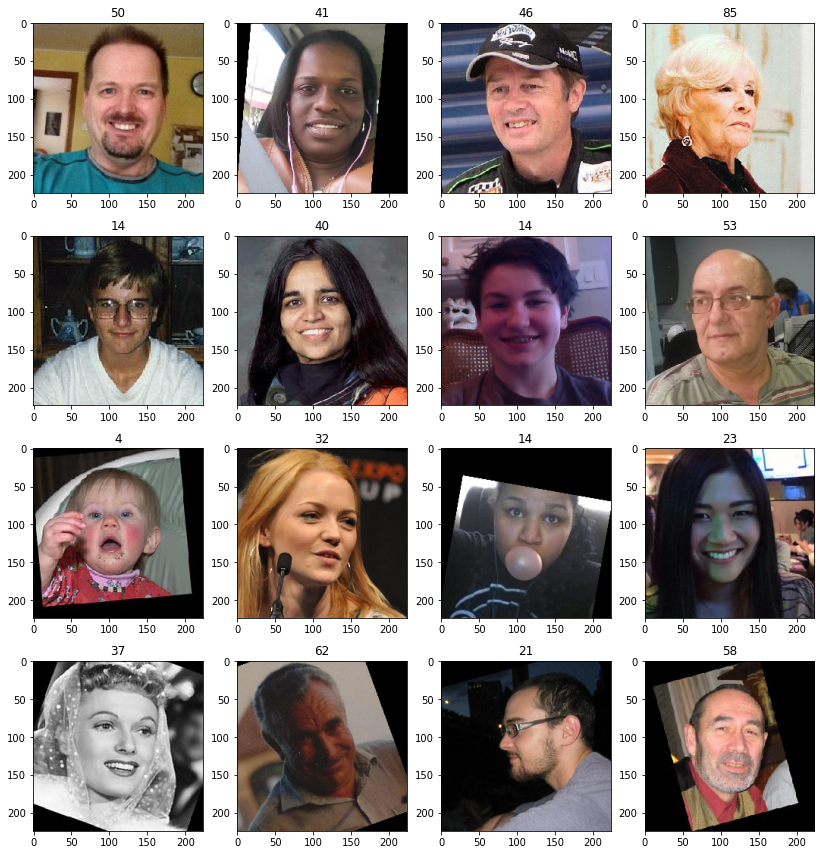

In [7]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(14,15))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])

**Вывод:**
Всего 7591 изображение. Большинство людей находятся в возрасте от 20 до 40 лет. Следовательно возраст людей выпадающих за этот интервал будет хуже предсказываться. Присутсвуют небрежности в фотография. Где-то человек расположен не в анфас, где-то фотография сдвинута. Это тоже может повлиять на точность предсказаний.

## Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python



from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model



```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 54s - loss: 239.9061 - mae: 11.0513 - val_loss: 382.0168 - val_mae: 14.5329
Epoch 2/10
356/356 - 42s - loss: 86.3730 - mae: 7.0404 - val_loss: 135.1083 - val_mae: 8.7524
Epoch 3/10
356/356 - 41s - loss: 58.7457 - mae: 5.8215 - val_loss: 89.7748 - val_mae: 7.0896
Epoch 4/10
356/356 - 42s - loss: 42.5469 - mae: 4.9997 - val_loss: 93.2972 - val_mae: 7.1072
Epoch 5/10
356/356 - 42s - loss: 31.9641 - mae: 4.3246 - val_loss: 84.0618 - val_mae: 6.8285
Epoch 6/10
356/356 - 43s - loss: 22.7759 - mae: 3.6778 - val_loss: 74.9455 - val_mae: 6.4461
Epoch 7/10
356/356 - 41s - loss: 19.5671 - mae: 3.3087 - val_loss: 73.0638 - val_mae: 6.3058
Epoch 8/10
356/356 - 44s - loss: 16.0127 - mae: 3.0551 - val_loss: 71.3416 - val_mae: 6.2129
Epoch 9/10
356/356 - 44s - loss: 13.6095 - mae: 2.7993 - val_loss: 69.0837 - val_mae: 6.3082
Epoch 10/10
356/356 - 45s - loss: 11.6790 - mae: 2.5997 - val_loss: 65.8105 - val_mae: 5.9637

119/119 - 11s - loss: 65.8105 - mae: 5.9637
Test MAE: 5.9637
```

## Анализ обученной модели

Для определения возраста людей обучена модель ResNet50 на 10 эпохах, с использованием алгоритма оптимизации Adam(lr=0.0001). На тесте итоговое отклонение составило 5.9367, что является неплохим показателем. Поэтому итоговую модель можно использовать. 